## LOAD LIBRARIES

In [ ]:
!pip install evds

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose


# web pattern
import requests
from bs4 import BeautifulSoup
import evds

# model
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error
from sklearn.impute import KNNImputer
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.callbacks import ModelCheckpoint,EarlyStopping

# visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.io as pio

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

## GET DATASET

**27 temmuz 2020 tarihinde BIST 100 endeksinden iki tane sıfır atıldı. Bu sebeple o tarih ve sonrasındaki verileri kullandım.**

In [ ]:
start_date = "2020-07-27"
bist100=yf.download("XU100.IS",start=start_date) # BIST100 verilerini indirelim

[*********************100%%**********************]  1 of 1 completed


## EDA

In [ ]:
bist100.shape

(779, 6)

In [ ]:
bist100.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-27,1199.599976,1203.400024,1194.400024,1195.699951,1195.699951,2729247100
2020-07-28,1197.099976,1198.199951,1152.699951,1152.699951,1152.699951,4094110200
2020-07-29,1156.000000,1159.699951,1121.000000,1135.599976,1135.599976,4345011800
2020-07-30,1137.199951,1137.199951,1124.599976,1126.900024,1126.900024,1403498000
2020-08-04,1140.400024,1143.300049,1064.900024,1087.199951,1087.199951,4294044700


In [ ]:
bist100.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-04,8141.299805,8238.900391,8126.000000,8141.299805,8141.299805,5212121500
2023-09-05,8161.100098,8236.099609,8090.200195,8236.099609,8236.099609,5547198400
2023-09-06,8291.599609,8298.500000,8127.899902,8181.700195,8181.700195,5981494100
2023-09-07,8218.500000,8358.000000,8218.500000,8337.700195,8337.700195,5098904900
2023-09-08,8371.330078,8398.440430,8348.419922,8390.009766,8390.009766,0


In [ ]:
bist100.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 779 entries, 2020-07-27 to 2023-09-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       779 non-null    float64
 1   High       779 non-null    float64
 2   Low        779 non-null    float64
 3   Close      779 non-null    float64
 4   Adj Close  779 non-null    float64
 5   Volume     779 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 42.6 KB


In [ ]:
bist100.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,779.0,2.856475e+03,1.815112e+03,1030.300049,1.424250e+03,2.048400e+03,4.479150e+03,8.371330e+03
High,779.0,2.890392e+03,1.842193e+03,1062.099976,1.434750e+03,2.059100e+03,4.563550e+03,8.398440e+03
Low,779.0,2.819322e+03,1.786103e+03,985.400024,1.415250e+03,2.015400e+03,4.436700e+03,8.348420e+03
Close,779.0,2.856765e+03,1.816088e+03,1034.400024,1.426850e+03,2.041400e+03,4.501450e+03,8.390010e+03
Adj Close,779.0,2.856765e+03,1.816088e+03,1034.400024,1.426850e+03,2.041400e+03,4.501450e+03,8.390010e+03
Volume,779.0,3.634720e+09,1.535646e+09,0.000000,2.467235e+09,3.407564e+09,4.691838e+09,9.457914e+09


In [ ]:
bist100.isnull().sum() # veride hiç boş değer yok

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
bist100.index=pd.to_datetime(bist100.index) # index veritipini datetime yaptık

## VISUALIZATION

In [ ]:
fig=go.Figure(data=[go.Candlestick(x=bist100.index,
                               open=bist100.Open,
                               close=bist100.Close,
                               low=bist100.Low,
                               high=bist100.High)]).update_layout()
fig.show()
pio.write_html(fig, file='bist100_close_open.html')

## TIME SERIES DECOMPOSITION - Bileşen analizi

**Toplamsal Yaklaşım Yöntemi ------->**
**y = T + S + R**

In [ ]:
bist100_close=bist100["Adj Close"]

In [ ]:
bist100_close.head()

Date
2020-07-27    1195.699951
2020-07-28    1152.699951
2020-07-29    1135.599976
2020-07-30    1126.900024
2020-08-04    1087.199951
Name: Adj Close, dtype: float64

**BIST 100 Endeksi Ocak-Mart, Nisan-Haziran, Temmuz-Eylül ve Ekim-Aralık olmak üzere 3 ayda bir yani senede 4 kere yeniden belirlenmektedir.**

In [ ]:
bist100_decompose = seasonal_decompose(bist100_close, model='additive',period=65) # verileri 3 aylık periyotlara böldük(hafta sonları dahil değil)

In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Close", "Trend", "Seasonal", "Resid"))

fig.add_trace(go.Scatter(x=bist100_close.index, y=bist100_close, mode='lines', line=dict(width=1)), row=1, col=1)
fig.add_trace(go.Scatter(x=bist100_decompose.trend.index, y=bist100_decompose.trend, mode='lines', line=dict(width=1)), row=1, col=2)
fig.add_trace(go.Scatter(x=bist100_decompose.seasonal.index, y=bist100_decompose.seasonal, mode='lines', line=dict(width=1)), row=2, col=1)
fig.add_trace(go.Scatter(x=bist100_decompose.resid.index, y=bist100_decompose.resid, mode='markers',
                         marker=dict(size=2, color=bist100_decompose.resid.apply(lambda x: 'red' if x < 0 else 'green'))), row=2, col=2)

fig.update_layout(
    showlegend=False,
    title_text="BIST100 Endeksi ve Bileşen Analizi",
    title_x=0.5,
    yaxis=dict(title="Value"),
    coloraxis=dict(colorbar=dict(title="Residual Color")),
    height=600,
    width=1000,
)

fig.show()
pio.write_html(fig, file='decompose.html')

## PREPROCESSING - DATA SCALING

In [ ]:
scaler=MinMaxScaler((1,5))

In [ ]:
bist100_scaled=scaler.fit_transform(bist100_close.to_numpy().reshape(-1,1)) # veriyi 1 ile 5 arasında normalize ettik
bist100_scaled[:5]

array([[1.08771533],
       [1.06433181],
       [1.0550328 ],
       [1.05030174],
       [1.02871274]])

In [ ]:
bist100_close=pd.DataFrame(bist100_close)
bist100_close["scaled_close"]=bist100_scaled
bist100_close.head()

,Adj Close,scaled_close
Date,,
2020-07-27,1195.699951,1.087715
2020-07-28,1152.699951,1.064332
2020-07-29,1135.599976,1.055033
2020-07-30,1126.900024,1.050302
2020-08-04,1087.199951,1.028713


In [ ]:
df=bist100_close.copy() # üzerinde çalışabilmek için yeni bir df oluşturduk

In [ ]:
df["date"]=df.index # tarih verisini üzerinde çalışabilmek için verisetine ekledik
df.head()

,Adj Close,scaled_close,date
Date,,,
2020-07-27,1195.699951,1.087715,2020-07-27
2020-07-28,1152.699951,1.064332,2020-07-28
2020-07-29,1135.599976,1.055033,2020-07-29
2020-07-30,1126.900024,1.050302,2020-07-30
2020-08-04,1087.199951,1.028713,2020-08-04


## VISUALIZATION - SCALED CLOSE PRICES

In [ ]:
fig=px.line(df,x="date",y="scaled_close").update_layout(title="BIST100 Scaled Close Prices")
fig.show()
pio.write_html(fig, file='bist100_scaled.html')

## FEATURE ENGINEERING - DATE

**tarih verilerinden öznitelik çıkarımı yapan fonksiyonu hazırlayalım.**

In [ ]:
def add_date_column(df, date_column_name):
    df['year'] = df[date_column_name].dt.year
    df['month'] = df[date_column_name].dt.month
    df['day'] = df[date_column_name].dt.day
    df['weekday'] = df[date_column_name].dt.weekday # haftanın kaçıncı günü
    df['yearweek'] = df[date_column_name].dt.isocalendar().week # yılın kaçıncı haftası
    df["period"] = df[date_column_name].dt.month.apply(lambda x:0 if x in [1,2,3] else 1 if x in [4, 5, 6] else 2 if x in [7, 8, 9] else 3 if x in [10, 11, 12] else None)

    return df

In [ ]:
df=add_date_column(df,"date")
df.head()

,Adj Close,scaled_close,date,year,month,day,weekday,yearweek,period
Date,,,,,,,,,
2020-07-27,1195.699951,1.087715,2020-07-27,2020,7,27,0,31,2
2020-07-28,1152.699951,1.064332,2020-07-28,2020,7,28,1,31,2
2020-07-29,1135.599976,1.055033,2020-07-29,2020,7,29,2,31,2
2020-07-30,1126.900024,1.050302,2020-07-30,2020,7,30,3,31,2
2020-08-04,1087.199951,1.028713,2020-08-04,2020,8,4,1,32,2


## VISUALIZATION - SCALED BIST100 ON PERIODS

In [ ]:
fig=px.line(df,x="date",y="scaled_close").update_layout(title="BIST100 Scaled Close Prices with Periods")
fig.show()
pio.write_html(fig, file='bist100_scaled_periods.html')

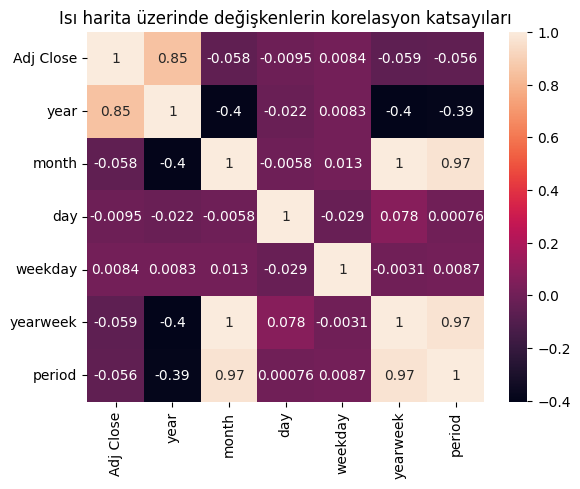

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.heatmap((df.drop(["scaled_close","date"],axis=1)).corr(),annot=True)
plt.title('Isı harita üzerinde değişkenlerin korelasyon katsayıları')
plt.show()
plt.savefig('df_cor.jpg')

## COVID-19



In [ ]:
# URL'yi belirtin
url = "https://tr.wikipedia.org/wiki/%C5%9Eablon:COVID-19_pandemisi_verileri/T%C3%BCrkiye_tablo_ve_grafikler"
# Web sayfasını alın
response = requests.get(url)
print(response.status_code)
# HTML içeriği BeautifulSoup ile işleyin
soup = BeautifulSoup(response.text, "html.parser")
# Veriyi içeren tabloyu bulun (örnekte ilk tabloyu alıyoruz)
table = soup.find("table", {"class": "sortable wikitable mw-datatable mw-collapsible"})
# Tabloyu DataFrame'e çevirmek için pandas'ı kullanabilirsiniz
import pandas as pd
covid_df = pd.read_html(str(table))[0]
covid_df.head()

200


Tarih Hasta sayısı                     Ölüm  ... İyileşen  \
          Tarih         Yeni Toplam Aktif[not 1] Yeni  ...   Toplam   
0  11 Mart 2020            1      1            -    0  ...        -   
1  12 Mart 2020            0      1            -    0  ...        -   
2  13 Mart 2020            4      5            -    0  ...        -   
3  14 Mart 2020            1      6            -    0  ...        -   
4  15 Mart 2020           12     18            -    1  ...        -   

  Ağır hastalar             Test sayısı         
         Entübe Yoğun bakım        Yeni Toplam  
0             -           -           -      -  
1             -           -           -      -  
2             -           -           -      -  
3             -           -           -      -  
4             -           -           -      -  

[5 rows x 12 columns]

In [ ]:
"""# Tarih sütununu datetime formatına çevirin
covid_df['Tarih'] = pd.to_datetime(df['Tarih'], format='%d %B %Y')

# Tarihi istediğiniz biçimde yeniden formatlayın
covid_df['Tarih'] = covid_df['Tarih'].dt.strftime('%d-%m-%Y')

# Sonuçları gösterin
print(covid_df)"""

"# Tarih sütununu datetime formatına çevirin\ncovid_df['Tarih'] = pd.to_datetime(df['Tarih'], format='%d %B %Y')\n\n# Tarihi istediğiniz biçimde yeniden formatlayın\ncovid_df['Tarih'] = covid_df['Tarih'].dt.strftime('%d-%m-%Y')\n\n# Sonuçları gösterin\nprint(covid_df)"

In [ ]:
"""month_covid = = covid_df["Tarih"].apply(lambda x: " ".join([aylar.get(word, word) for word in x.split()]))

# Sonuçları göster
month_covid.head()"""

'month_covid = = covid_df["Tarih"].apply(lambda x: " ".join([aylar.get(word, word) for word in x.split()]))\n\n# Sonuçları göster\nmonth_covid.head()'

In [ ]:
"""month_covid = covid_df["Tarih"][:].to_string()
month_covid.replace(["Ocak","Şubat","Mart","Nisan","Mayıs","Haziran","Temmuz","Ağustos","Eylül","Ekim","Kasım","Aralık"],
                                                       ["01","02","03","04","05","06","07","08","09","10","11","12"]).split("\n")"""

'month_covid = covid_df["Tarih"][:].to_string()\nmonth_covid.replace(["Ocak","Şubat","Mart","Nisan","Mayıs","Haziran","Temmuz","Ağustos","Eylül","Ekim","Kasım","Aralık"],\n                                                       ["01","02","03","04","05","06","07","08","09","10","11","12"]).split("\n")'

**Türkçe karakterler sorun çıkarttı**

## TCMB API

In [ ]:
api = evds.evdsAPI('ZOlbbrnBi8')

In [ ]:
api.main_categories # ANA KATEGORİLERİ LİSTELEDİK

,CATEGORY_ID,TOPIC_TITLE_TR
0,1,PİYASA VERİLERİ
1,2,KURLAR
2,3,FAİZ İSTATİSTİKLERİ
3,4,PARA VE BANKA İSTATİSTİKLERİ
4,5,MENKUL KIYMET İSTATİSTİKLERİ
...,...,...
18,25,ALTIN VERİLERİ
19,26,KONUT VE İNŞAAT İSTATİSTİKLERİ
20,27,FİNANSAL HESAPLAR
21,28,TURİZM İSTATİSTİKLERİ


In [ ]:
api.get_sub_categories(3) # FAİZ İSTATİSTİKLERİ

,CATEGORY_ID,DATAGROUP_CODE,DATAGROUP_NAME
0,3,bie_kt100h,Bankalarca Açılan Kredilere Uygulanan Ağırlıkl...
1,3,bie_mt100h,Bankalarca Açılan Mevduatlara Uygulanan Ağırlı...
2,3,bie_mt210as,Bankalarca Mevduatlara Fiilen Uygulanan Azami ...
3,3,bie_mt210ak,Kamu Bankalarınca Mevduatlara Fiilen Uygulanan...
4,3,bie_mt210ags,Bankalarca Açılan Mevduatlara Uygulanan Ağırlı...
5,3,bie_reesavans,Reeskont ve Avans Faiz Oranları (%)


In [ ]:
api.get_sub_categories(4) # PARA VE BANKA VERİLERİ

,CATEGORY_ID,DATAGROUP_CODE,DATAGROUP_NAME
0,4,bie_prarz,"Haftalık, Para Arzı (Bin TL)"
1,4,bie_bosecbil,"Haftalık, Seçilmiş Bilanço Büyüklükleri - Bank..."
2,4,bie_kredi,"Haftalık, Krediler - Bankacılık Sektörü (Bin TL)"
3,4,bie_bftukkre,"Haftalık, Krediler - Bankalar ve Finansman Şir..."
4,4,bie_tukkre,"Haftalık, Tüketici Kredileri (Orijinal Vadeye ..."
...,...,...,...
33,4,bie_kmbscz,"Aylık, Menkul Değerler, Bankacılık Sektörü (Bi..."
34,4,bie_kmmbkcz,"Aylık, Menkul Değerler (Kurumsal Sektörlere Gö..."
35,4,bie_kavramsal,"Haftalık, Para Arzı - Kavramsal Tutar Endeksi ..."
36,4,bie_krehacbs,"Aylık, Kredi Hacmi, Bankacılık Sektörü (Bin TL..."


In [ ]:
api.get_sub_categories(23) # İSTİHDAM

,CATEGORY_ID,DATAGROUP_CODE,DATAGROUP_NAME
0,23,bie_tisguc,Mevsim etkisinden arındırılmış temel işgücü gö...
1,23,bie_yisgucu2,Temel işgücü göstergeleri(TÜİK)(Bin Kişi - 15+...


In [ ]:
api.get_sub_categories(14) # FİYAT ENDEKSLERİ

,CATEGORY_ID,DATAGROUP_CODE,DATAGROUP_NAME
0,14,bie_tukfiy4,Fiyat Endeksi (Tüketici)(2003=100)(TÜİK)
1,14,bie_feoktg,Fiyat Endeksi-Özel Kapsamlı TÜFE Göstergeleri ...
2,14,bie_tufe1yi,Fiyat Endeksi (Yurt İçi Üretici Fiyatları)(200...
3,14,bie_ufeyd,Fiyat Endeksi (Yurt Dışı Üretici Fiyatları)(20...
4,14,bie_ito68,Geçinme Endeksi (Ücretliler)(1968=100)(İTO)
...,...,...,...
6,14,bie_itouge85,Geçinme Endeksi (Ücretliler)-İstanbul (1985=10...
7,14,bie_itotefe,Fiyat Endeksi (Toptan Eşya)(1968=100)(İTO)
8,14,bie_itoteuc,Fiyat (Toptan Eşya) ve Geçinme (Ücretliler) En...
9,14,bie_tuufey,Tarım Ürünleri Üretici Fiyat Endeksi (2015=100...


## LOAD DATA - PETROL VARIL FIYATLARI

In [ ]:
api.get_series("bie_brentpetrol")

,SERIE_CODE,SERIE_NAME,START_DATE
0,TP.BRENTPETROL.EUBP,Avrupa Brent Petrol Spot FOB Fiyatı (Varil Baş...,20-05-1987


In [ ]:
petrol=api.get_data(['TP.BRENTPETROL.EUBP'], startdate="17-07-2020",enddate="07-09-2023")
petrol.head()

,Tarih,TP_BRENTPETROL_EUBP
0,17-07-2020,43.53
1,20-07-2020,43.30
2,21-07-2020,44.31
3,22-07-2020,43.98
4,23-07-2020,42.96


In [ ]:
petrol.isnull().sum()

Tarih                   0
TP_BRENTPETROL_EUBP    15
dtype: int64

## İSTİHDAM

In [ ]:
api.get_series("bie_tisguc")

,SERIE_CODE,SERIE_NAME,START_DATE
0,TP.TIG01,15 ve daha yukarı yaştaki nüfus,01-01-2014
1,TP.TIG02,İşgücü,01-01-2014
2,TP.TIG03,İstihdam edilenler,01-01-2014
3,TP.TIG04,İşsiz,01-01-2014
4,TP.TIG05,İşgücüne dahil olmayan nüfus,01-01-2014
5,TP.TIG06,İşgücüne katılma oranı (%),01-01-2014
6,TP.TIG07,İstihdam oranı (%),01-01-2014
7,TP.TIG08,İşsizlik oranı (%),01-01-2014


In [ ]:
"""employment=api.get_data(['TP.TIG08',"TP.TIG07"], startdate="17-07-2020",enddate="07-09-2023")
employment.columns=["date","unemployment_rate","employment_rate"]
employment["month"]=employment["date"].dt.month
employment.head()"""

'employment=api.get_data([\'TP.TIG08\',"TP.TIG07"], startdate="17-07-2020",enddate="07-09-2023")\nemployment.columns=["date","unemployment_rate","employment_rate"]\nemployment["month"]=employment["date"].dt.month\nemployment.head()'

## NEW DATASET ANALYSIS

In [ ]:
df.head()

,Adj Close,scaled_close,date,year,month,day,weekday,yearweek,period
Date,,,,,,,,,
2020-07-27,1195.699951,1.087715,2020-07-27,2020,7,27,0,31,2
2020-07-28,1152.699951,1.064332,2020-07-28,2020,7,28,1,31,2
2020-07-29,1135.599976,1.055033,2020-07-29,2020,7,29,2,31,2
2020-07-30,1126.900024,1.050302,2020-07-30,2020,7,30,3,31,2
2020-08-04,1087.199951,1.028713,2020-08-04,2020,8,4,1,32,2


In [ ]:
df.drop(["Adj Close","date"],axis=1,inplace=True)
df.head()

,scaled_close,year,month,day,weekday,yearweek,period
Date,,,,,,,
2020-07-27,1.087715,2020,7,27,0,31,2
2020-07-28,1.064332,2020,7,28,1,31,2
2020-07-29,1.055033,2020,7,29,2,31,2
2020-07-30,1.050302,2020,7,30,3,31,2
2020-08-04,1.028713,2020,8,4,1,32,2


## TRAIN-TEST SPLIT

In [ ]:
# Veri çerçevesinin başlangıç ve bitiş tarihlerini belirleyin
train_end_date = "2023-03-31"  # Eğitim verisi son tarihi
test_start_date = "2023-04-01"  # Test verisi ilk tarihi

# Veriyi bölmek için tarih aralıklarını kullanın
train = df[df.index <= train_end_date]
test = df[df.index >= test_start_date]

In [ ]:
x_train=train.drop("scaled_close",axis=1)
x_test=test.drop("scaled_close",axis=1)
y_train=train["scaled_close"]
y_test=test["scaled_close"]

## MODELLING - LSTM

In [ ]:
x_train_lstm = x_train.to_numpy().reshape(x_train.shape[0], x_train.shape[1], 1).astype(np.float32)
x_test_lstm = x_test.to_numpy().reshape(x_test.shape[0], x_test.shape[1], 1).astype(np.float32)
y_test_lstm = y_test.astype(np.float32)
y_train_lstm = y_train.astype(np.float32)

In [ ]:
# LSTM modeli oluşturma
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
# Modeli derleme
model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

In [ ]:
# Modeli eğitme
model.fit(x_train_lstm, y_train, batch_size=16, epochs=10)
y_pred=model.predict(x_test_lstm)
mean_absolute_percentage_error(y_true=y_test_lstm,y_pred=y_pred)

Epoch 1/10
42/42 [==============================] - 11s 19ms/step - loss: 33.4672
Epoch 2/10
42/42 [==============================] - 1s 22ms/step - loss: 23.8643
Epoch 3/10
42/42 [==============================] - 1s 21ms/step - loss: 23.3391
Epoch 4/10
42/42 [==============================] - 1s 22ms/step - loss: 22.9138
Epoch 5/10
42/42 [==============================] - 1s 20ms/step - loss: 22.8454
Epoch 6/10
42/42 [==============================] - 1s 21ms/step - loss: 22.8799
Epoch 7/10
42/42 [==============================] - 1s 30ms/step - loss: 23.2320
Epoch 8/10
42/42 [==============================] - 1s 31ms/step - loss: 22.8914
Epoch 9/10
42/42 [==============================] - 1s 27ms/step - loss: 22.9570
Epoch 10/10
4/4 [==============================] - 3s 9ms/step


0.6644695

## MODELLING - CATBOOST

In [ ]:
model=CatBoostRegressor()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
mean_absolute_percentage_error(y_pred=y_pred,y_true=y_test) # 0.20607001952718484

Learning rate set to 0.038442
0:	learn: 0.6944481	total: 1.79ms	remaining: 1.79s
1:	learn: 0.6706458	total: 2.19ms	remaining: 1.09s
2:	learn: 0.6483188	total: 2.67ms	remaining: 888ms
3:	learn: 0.6295316	total: 3.17ms	remaining: 789ms
4:	learn: 0.6076034	total: 3.58ms	remaining: 713ms
5:	learn: 0.5863501	total: 4ms	remaining: 662ms
6:	learn: 0.5670957	total: 4.39ms	remaining: 623ms
7:	learn: 0.5482419	total: 4.77ms	remaining: 591ms
8:	learn: 0.5297955	total: 5.14ms	remaining: 566ms
9:	learn: 0.5123471	total: 5.51ms	remaining: 546ms
10:	learn: 0.4959470	total: 5.86ms	remaining: 527ms
11:	learn: 0.4791410	total: 6.27ms	remaining: 516ms
12:	learn: 0.4632491	total: 7.42ms	remaining: 564ms
13:	learn: 0.4487218	total: 7.99ms	remaining: 562ms
14:	learn: 0.4341745	total: 10.2ms	remaining: 672ms
15:	learn: 0.4208438	total: 10.6ms	remaining: 654ms
16:	learn: 0.4071645	total: 15.7ms	remaining: 910ms
17:	learn: 0.3944888	total: 16.2ms	remaining: 883ms
18:	learn: 0.3808923	total: 16.6ms	remaining: 8

0.28751505756875345

**CatBoost - Test & Prediction datasets visualization**

In [ ]:
result=pd.DataFrame()
result["close"]=y_test
result["predicted_close"]=y_pred
result_arr=np.array(result["close"]).reshape(-1,1)
result_arr=scaler.inverse_transform(result_arr)
result_arr_pr=np.array(result["predicted_close"]).reshape(-1,1)
result_arr_pr=scaler.inverse_transform(result_arr_pr)

result["close"]=result_arr
result["predicted_close"]=result_arr_pr

# Plot
fig = px.line(result, x=result.index, y=["close","predicted_close"]).update_layout(yaxis=dict(
        title='BIST100 Close Prices'),title="CatBoost - Test & Prediction datasets visualization - 2023-04-01 / 2023-08-07")
fig.show()
pio.write_html(fig, file='catboost_test_pred.html')

## MODELLING - LGBMBOOST

In [ ]:
model=LGBMRegressor()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
mean_absolute_percentage_error(y_pred=y_pred,y_true=y_test) # 0.15328085648566347

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 671, number of used features: 6
[LightGBM] [Info] Start training from score 1.716874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

0.14880821850372297

**LightGBM - Test & Prediction datasets visualization**

In [ ]:
result=pd.DataFrame()
result["close"]=y_test
result["predicted_close"]=y_pred
result_arr=np.array(result["close"]).reshape(-1,1)
result_arr=scaler.inverse_transform(result_arr)
result_arr_pr=np.array(result["predicted_close"]).reshape(-1,1)
result_arr_pr=scaler.inverse_transform(result_arr_pr)

result["close"]=result_arr
result["predicted_close"]=result_arr_pr

# Plot
fig = px.line(result, x=result.index, y=["close","predicted_close"]).update_layout(yaxis=dict(
        title='BIST100 Close Prices'),title="LightGBM - Test & Prediction datasets visualization - 2023-04-01 / 2023-08-07")
fig.show()
pio.write_html(fig, file='LGBM_test_pred.html')

In [ ]:
result

,close,predicted_close
Date,,
2023-04-03,4839.500000,5142.594687
2023-04-04,4984.100098,5139.543031
2023-04-05,4919.899902,5134.642509
2023-04-06,4912.799805,5147.256205
2023-04-07,4924.600098,5113.567628
...,...,...
2023-09-04,8141.299805,5147.892099
2023-09-05,8236.099609,5142.570306
2023-09-06,8181.700195,5145.055989


## GELECEK 3 AY TAHMIN

In [ ]:
from datetime import datetime, timedelta

current_date = datetime.now()
end_date = current_date + timedelta(days=90)  # Gelecek 3 ayın sonu
start_date = current_date + timedelta(days=1)  # Gelecek 3 ayın başı (bir sonraki gün)

print("Başlangıç Tarihi:", start_date.strftime("%Y-%m-%d"))
print("Bitiş Tarihi:", end_date.strftime("%Y-%m-%d"))
train = df[(df.index >= start_date) & (df.index < end_date)]
test = df[df.index >= end_date]
train_weekdays = train[(train.index.weekday >= 0) & (train.index.weekday < 5)]
test_weekdays = test[(test.index.weekday >= 0) & (test.index.weekday < 5)]


Başlangıç Tarihi: 2023-09-09
Bitiş Tarihi: 2023-12-07


In [ ]:
x_train=df.drop("scaled_close",axis=1)
y_train=df["scaled_close"]
x_train

,year,month,day,weekday,yearweek,period
Date,,,,,,
2020-07-27,2020,7,27,0,31,2
2020-07-28,2020,7,28,1,31,2
2020-07-29,2020,7,29,2,31,2
2020-07-30,2020,7,30,3,31,2
2020-08-04,2020,8,4,1,32,2
...,...,...,...,...,...,...
2023-09-04,2023,9,4,0,36,2
2023-09-05,2023,9,5,1,36,2
2023-09-06,2023,9,6,2,36,2


In [ ]:
from datetime import datetime, timedelta
import pandas as pd

# Şu anki tarihi alın
current_date = datetime.now()

# Gelecek 3 ayın son tarihini hesaplayın
end_date = current_date + timedelta(days=90)

# Başlangıç tarihini bir sonraki iş günü olarak ayarlayın (eğer şu anki gün hafta içi ise)
if current_date.weekday() < 4:  # Hafta içi günleri (0'dan 4'e kadar)
    start_date = current_date + timedelta(days=1)
else:
    start_date = current_date + timedelta(days=(7 - current_date.weekday()) + 1)

# Tarih aralığındaki hafta içi günlerini içeren bir tarih dizisi oluşturun
date_range = pd.date_range(start=start_date, end=end_date, freq='B')

# Bu tarihleri kullanarak yeni bir veri çerçevesi oluşturun
new_df = pd.DataFrame({'date_column_name': date_range})

# Diğer gerekli sütunları ekleyebilirsiniz, örneğin:
# new_df['column_name'] = ...

# Hafta içi günlerini içeren test verisini oluşturun
new_df = add_date_column(new_df, 'date_column_name')  # Tarih sütununu biçimlendirmek için kullanılan fonksiyon

# Tarih sütununu "2020-07-28" gibi bir formata çevirin
new_df['date_column_name'] = new_df['date_column_name'].dt.strftime("%Y-%m-%d")

# Veri çerçevesinin index'ini tarih sütunu olarak ayarlayın
new_df.set_index('date_column_name', inplace=True)

# Şimdi new_df veri çerçevesi, istediğiniz tarih aralığındaki hafta içi günlerini içeren veriyi içerir ve tarih sütununu istediğiniz formatta gösterir.


In [ ]:
new_df

,year,month,day,weekday,yearweek,period
date_column_name,,,,,,
2023-09-12,2023,9,12,1,37,2
2023-09-13,2023,9,13,2,37,2
2023-09-14,2023,9,14,3,37,2
2023-09-15,2023,9,15,4,37,2
2023-09-18,2023,9,18,0,38,2
...,...,...,...,...,...,...
2023-12-01,2023,12,1,4,48,3
2023-12-04,2023,12,4,0,49,3
2023-12-05,2023,12,5,1,49,3


# LGBM PREDICTION

In [ ]:
model=LGBMRegressor()
model.fit(x_train,y_train)
y_pred=model.predict(new_df)
y_pred=pd.Series(y_pred)
y_pred.index=new_df.index
y_pred

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 779, number of used features: 6
[LightGBM] [Info] Start training from score 1.991007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

date_column_name
2023-09-12    4.703760
2023-09-13    4.700147
2023-09-14    4.705479
2023-09-15    4.711424
2023-09-18    4.638085
                ...   
2023-12-01    4.716272
2023-12-04    4.694853
2023-12-05    4.696988
2023-12-06    4.700001
2023-12-07    4.707021
Length: 63, dtype: float64

In [ ]:
y_pred = y_pred.rename_axis('date')

In [ ]:
fig=px.line(y_pred).update_layout(title="LightGBM Prediction next 3 months",yaxis=dict(
        title='BIST100 Close Prices'),xaxis=dict(title='date_next_3_months'))
fig.update_traces(showlegend=False)
fig.show()
pio.write_html(fig, file='LGBM_pred_next_3_months.html')

## CATBOOST PRED NEXT 3 MONTHS

In [ ]:
model=CatBoostRegressor()
model.fit(x_train,y_train)
y_pred=model.predict(new_df)
y_pred=pd.Series(y_pred)
y_pred.index=new_df.index
y_pred

Learning rate set to 0.039359
0:	learn: 0.9536798	total: 720us	remaining: 720ms
1:	learn: 0.9224052	total: 1.26ms	remaining: 629ms
2:	learn: 0.8904893	total: 9.22ms	remaining: 3.06s
3:	learn: 0.8596700	total: 11.6ms	remaining: 2.89s
4:	learn: 0.8300730	total: 13.1ms	remaining: 2.61s
5:	learn: 0.8018048	total: 14.5ms	remaining: 2.41s
6:	learn: 0.7741974	total: 15.7ms	remaining: 2.23s
7:	learn: 0.7496429	total: 17ms	remaining: 2.1s
8:	learn: 0.7231008	total: 18ms	remaining: 1.98s
9:	learn: 0.6972898	total: 19.1ms	remaining: 1.9s
10:	learn: 0.6737274	total: 20.5ms	remaining: 1.84s
11:	learn: 0.6529651	total: 21.5ms	remaining: 1.77s
12:	learn: 0.6310323	total: 22.6ms	remaining: 1.72s
13:	learn: 0.6098704	total: 24.2ms	remaining: 1.71s
14:	learn: 0.5893980	total: 25.1ms	remaining: 1.65s
15:	learn: 0.5696047	total: 26.8ms	remaining: 1.65s
16:	learn: 0.5499909	total: 27.7ms	remaining: 1.6s
17:	learn: 0.5323437	total: 28.8ms	remaining: 1.57s
18:	learn: 0.5150741	total: 29.7ms	remaining: 1.53s


date_column_name
2023-09-12    4.883654
2023-09-13    4.846370
2023-09-14    4.844070
2023-09-15    4.835661
2023-09-18    4.647481
                ...   
2023-12-01    2.883161
2023-12-04    2.801805
2023-12-05    2.803943
2023-12-06    2.765519
2023-12-07    2.808529
Length: 63, dtype: float64

In [ ]:
y_pred = y_pred.rename_axis('date')

In [ ]:
# Grafiği oluşturun
fig = px.line(y_pred)

# Legend (lejant) ismini değiştirin
fig.update_traces(name='catboost_pred')  # 'Yeni Legend İsmi' uygun isimle değiştirilmelidir

# Layout ayarlarını yapın
fig.update_layout(
    title="CatBoost Prediction next 3 months",
    yaxis=dict(title='BIST100 Close Prices'),
    xaxis=dict(title='date_next_3_months'),
)
fig.update_traces(showlegend=False)

# Grafiği gösterin
fig.show()
pio.write_html(fig, file='catboost_pred_next_3_months.html')